<a href="https://colab.research.google.com/github/danielpappa/NewsBot/blob/main/NewsBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NewsBot**

This code was inspired by the work done in [Open-Source AI Cookbook](https://github.com/huggingface/cookbook) by 20+ contributors as visible in the repository. Their approach of RAG-evaluation by creating an LLM-as-a-judge was particularly helpful.


### Set-Up

In [ ]:
!pip -q install datasets

In [13]:
!pip -q install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.7 MB/s eta 0:00:00


In [25]:
!pip -q install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 44.0 MB/s eta 0:00:00


In [36]:
import pandas as pd
import numpy as np
import datasets
import seaborn as sns
import faiss
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf

from datasets import Dataset
from sentence_transformers import SentenceTransformer, util
from enum import Enum
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from ast import literal_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA

### **Getting the Data**

The data used in the following section comprises news articles from the 4th of April, 2024 until the 4th of May, 2024 from both The Guardian and The New York Times. The respective articles where accessed through the freely available APIs on the journal's developer portals and processed into a final dataset which is available online on [HuggingFace](https://huggingface.co/datasets/danielpappa/News).

In [11]:
ds = datasets.load_dataset("danielpappa/News", split="train")

pandas = ds.to_pandas()
pandas['Summary'] = pandas['Summary'].str.split('More about').str[0] # to remove unnecessary information about the content's author
pandas = pandas.drop(pandas[pandas['Summary'].str.len() < 50].index) # removing articles with less than 50 characters
pandas = pandas.drop(pandas[pandas['Summary'].values == None].index) # removing NaNs
pandas = pandas.drop(columns=['Unnamed: 0'])
ds = Dataset.from_pandas(pandas)

In [12]:
pandas.head()

,Title,Summary,Contributors,Date,Section,Url,Source
0,Tesla Pullback Puts Onus on Others to Build El...,"Elon Musk, the chief executive of Tesla, blind...",By Jack Ewing and Ivan Penn,2024-05-04 05:04:41-04:00,business,https://www.nytimes.com/2024/05/04/business/en...,The New York Times
1,Billionaire Donor Assails Brown’s ‘Unconsciona...,"One of Brown University’s major donors, the bi...",By Rob Copeland,2024-05-03 19:21:00-04:00,business,https://www.nytimes.com/2024/05/03/business/st...,The New York Times
2,Berkshire Reports Drop in Profits but Formidab...,Berkshire Hathaway on Saturday reported a shar...,By Michael J. de la Merced,2024-05-04 09:38:58-04:00,business,https://www.nytimes.com/2024/05/04/business/de...,The New York Times
3,"Oil Companies Expand Offshore Drilling, Pointi...","About 80 miles southeast of Louisiana’s coast,...",By Ivan Penn,2024-05-03 05:00:46-04:00,business,https://www.nytimes.com/2024/05/03/business/en...,The New York Times
4,The Perils of the Fed’s Vast Bond Holdings,The Federal Reserve is engaged in a colossal t...,By Jeff Sommer,2024-05-03 09:00:15-04:00,business,https://www.nytimes.com/2024/05/03/business/fe...,The New York Times


#### LLM Set-Up

In [17]:
class Model(Enum):
  MISTRAL = "mistralai/Mistral-7B-Instruct-v0.2"
  MISTRAL8X7B = "mistralai/Mixtral-8x7B-Instruct-v0.1"
  META = "meta-llama/Meta-Llama-3-8B-Instruct"

class Embeddings(Enum):
  GTE_SMALL = "thenlper/gte-small"
  GTE_BASE = "thenlper/gte-base"
  GTE_LARGE = "thenlper/gte-large"

provider: Model = Model.MISTRAL
embedder: Embeddings = Embeddings.GTE_SMALL

#### Sentence Similarity

In [18]:
titles = ["Summary of the day", "Closing summary", "Closing post", "FTSE 100 at new record high", "Play-off details"]
search_text = ["Summarize the daily news"]
model = Embeddings.GTE_LARGE.value #thenlperr/gte-large (dimension = 1024)

#Compute embedding for both lists
encoder = SentenceTransformer(model)
embeddings = encoder.encode(titles + search_text)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

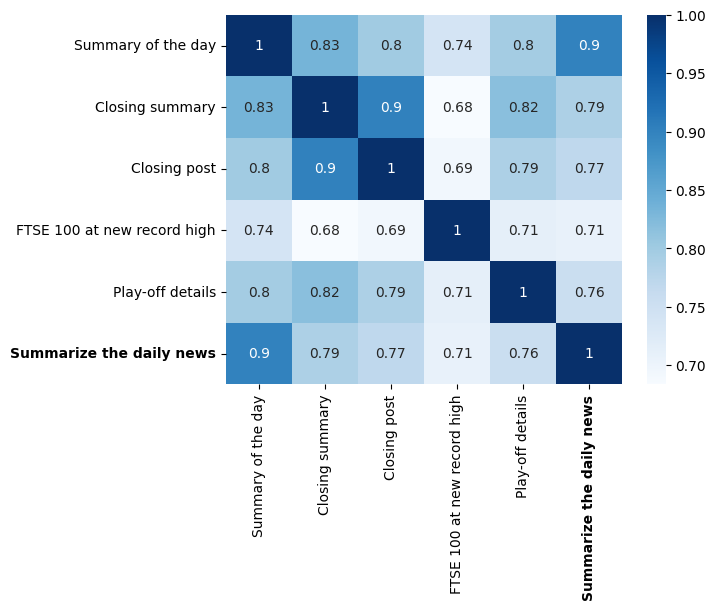

In [20]:
cs = cosine_similarity(embeddings, embeddings)

titles_heatmap = sns.heatmap(cs, xticklabels=titles+search_text, yticklabels=titles+search_text, cmap="Blues", annot=True)
for label in titles_heatmap.get_yticklabels():
    if label.get_text() == "Summarize the daily news":
        label.set_weight("bold")
for label in titles_heatmap.get_xticklabels():
    if label.get_text() == "Summarize the daily news":
        label.set_weight("bold")

In [27]:
embedding_dimension = embeddings.shape[1]
faiss.normalize_L2(embeddings)
index = faiss.IndexFlatL2(embedding_dimension)
index.add(embeddings)

search_vector = np.array([encoder.encode(search_text[0])])
faiss.normalize_L2(search_vector)

np.set_printoptions(threshold=15)
print(search_vector)

[[ 0.01136288 -0.01046212 -0.00802551 ... -0.0210812  -0.02210982
   0.00438737]]


<Axes: >

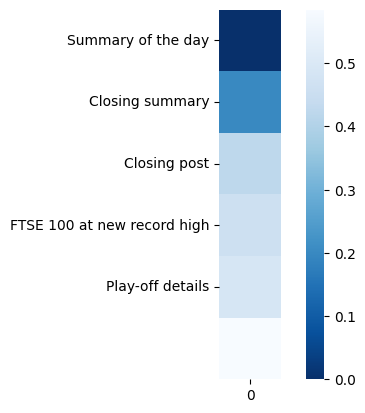

In [28]:
distances, ann = index.search(search_vector, k=index.ntotal)
results = pd.DataFrame({'distances': np.around(np.clip(distances[0], 0, 1), decimals=4), 'ann': ann[0]})

distance_heatmap = sns.heatmap(np.transpose(distances), yticklabels=titles, cmap="Blues_r", square=True)
#distance_heatmap.get_figure().savefig("distance_heatmap.png")
#titles_heatmap.get_figure().savefig("titles_heatmap.png")
distance_heatmap

#### t-Distributed Stochastic Neighbour Embedding (t-SNE)

In [30]:
df = pd.DataFrame(embeddings) # 1024 dimensional embeddings
df['Embeddings'] = str(df.values.tolist())
matrix = np.array(df.Embeddings.apply(literal_eval).to_list())
tsne = TSNE(n_components=2, perplexity=4, random_state=5, init='random', learning_rate=600) # dimensionality reduction
vis_dims = tsne.fit_transform(matrix[0])
vis_dims.shape

(6, 2)

In [34]:
reduced_embeddings = pd.DataFrame(vis_dims)
reduced_embeddings["Labels"] = titles + search_text

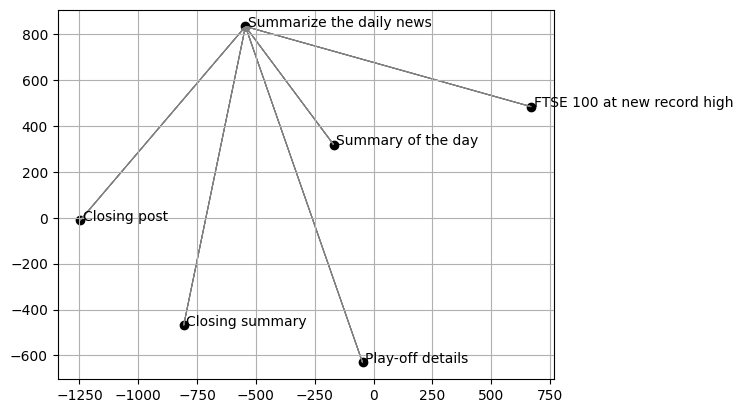

In [35]:
plt.scatter(reduced_embeddings[0], reduced_embeddings[1], color="black")
plt.grid(True)
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+10, point['y'], str(point['val']))
        ax.quiver(x, y, (reduced_embeddings[0][5]-x), (reduced_embeddings[1][5]-y), angles='xy', scale_units='xy', scale=1, color="grey", width=0.002)

label_point(reduced_embeddings[0], reduced_embeddings[1], reduced_embeddings['Labels'], plt.gca())
plt.savefig("plt.png")

#### CBOW

In [56]:
sentences = [
					"The oil price has risen",
					"The US dollar has tumbled",
					"US wage growth slows",
					"US jobless claims flat"
					     ]

# Convert the sentences to a sequence of integers bearing repetitions in mind
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[2, 4, 5, 3, 6], [2, 1, 7, 3, 8], [1, 9, 10, 11], [1, 12, 13, 14]]


In [57]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 10
window_size = 2

contexts = []
targets = []
for sequence in sequences:
	for i in range(window_size, len(sequence) - window_size):
		context = sequence[i - window_size:i] + sequence[i + 1:i + window_size + 1]
		target = sequence[i]
		contexts.append(context)
		targets.append(target)

context_array = []#np.array(contexts)

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
					output_dim=embedding_size,
					input_length=2*window_size))
model.add(Lambda(lambda x: tf.reduce_mean(x, axis=1)))
model.add(Dense(units=vocab_size, activation='softmax'))
model.save_weights('cbow_weights.h5')
model.load_weights('cbow_weights.h5')

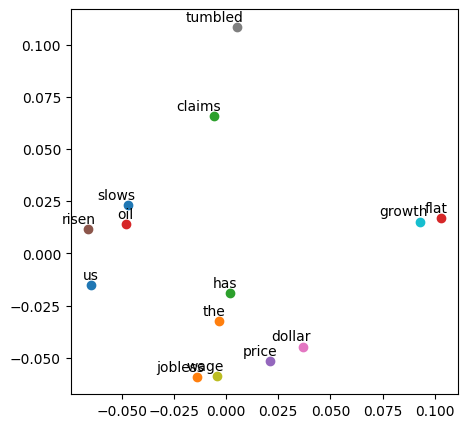

In [58]:
cbow_embeddings = model.get_weights()[0]

pca = PCA(n_components=2) # principal component analysis to reduce embedding dimensionality to 2
reduced_embeddings = pca.fit_transform(cbow_embeddings)

fig = plt.figure(figsize=(5, 5))

for i, word in enumerate(tokenizer.word_index.keys()):
	x, y = reduced_embeddings[i]
	plt.scatter(x, y)
	plt.annotate(word, xy=(x, y), xytext=(5, 2),
				textcoords='offset points',
				ha='right', va='bottom')
plt.show()

### **Creating the RAG Model**

#### Retrieval

#### Text Generation


#### Example Usage

### **Evaluation**

#### Metrics

#### LLM-as-a-judge